## Predict if a customer will make a possible transaction in future or not

In [1]:
import sys
#Change path to wherever you place this project
sys.path.append('C:\\Users\\PAT\\Documents\\edwisor\\projects\\Santander')

#Do all imports
from Santander import *
from Santander.config import *

Using TensorFlow backend.


In [28]:
data = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

full_data = [data,test] #this list will be used iterate for cleanup purposes

In [29]:
data.head(2)

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,0.394657,0.354099,0.660396,0.831914,0.454638,0.534519,0.430096,0.292094,0.731940,...,0.256380,0.680266,0.148181,0.617554,0.358041,0.389838,0.372360,0.522623,0.475872,0.511229
1,0,0.579193,0.674664,0.706391,0.591648,0.377997,0.762323,0.596118,0.411857,0.388079,...,0.285676,0.728479,0.224801,0.703507,0.590956,0.589556,0.505505,0.521153,0.508496,0.723995


In [155]:
#Size of dataset and testset
data.shape,test.shape

((200000, 202), (12886, 201))

In [105]:
#Since columns are huge, let us see overview of data type spresent
data.dtypes.unique()
#mainly numeric and ID_Code as object

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [30]:
#Let's drop ID_code - just ordering of observations, we have row index for that
data = data.drop(['ID_code'], axis =1)
test = test.drop(['ID_code'], axis =1)

full_data=[data,test]#update
data.shape,test.shape

((20000, 201), (12886, 200))

In [25]:
#Functions block
def get_fn_ratio(dv):
    return len(dv[dv == 0]),len(dv[dv == 1])

def best_fxn(skew_kurt_dic):
    for dataser in skew_kurt_dic.keys():
        for col in skew_kurt_dic[dataset].keys():
            print(skew_kurt_dic[dataset][col].keys())
            
def skew_kurt_analysis(data,label_,col, skew_kurt_dic,printhist = False,printverbose=True):
    if printverbose:
        print('---------------%s---------------'%label_)
    if(printhist):
        print(data.hist(label = label_))
    skew_ =  skew(data)
    
    if printverbose:
        print('Skewness : ',skew_)
    if abs(skew_) < 0.5 :
        txt = '%%%%%Moderately symm'
    else:
        txt = '+++++very %s skewed'%('Right/positive(tail/majority towards right)' if skew_ > 0 else 'Left/negative(tail/majority towards left)')
    if printverbose:
        print(txt)
    kurtosis_ =  kurtosis(data)
    if printverbose:
        print('Kurtosis : ',kurtosis_)
    if abs(kurtosis_) < 0.5 :
        txt = '%%%%%%%%%Moderately Bell shaped'
    else:
        txt = '^^^^^^^^Pointy' if kurtosis_ >0 else '~~~~~~~~~~Flat'
    if printverbose:
        print(txt)
    skew_kurt_dic[col][label_] = (skew_,kurtosis_)
    #skew_kurt_dic[col]['maxlabel'] = ''
    return skew_kurt_dic

def key_withmax_value(dic):
    for key in dic.keys():
        if max <  dic[key]:
            max = dic[key]
    inv_map = {v:k for k,v in dic.items()}
    return inv_map[max]

def maxlabel(dic):
    label_ = 'original'
    for label in dic.keys():
        if label == 'maxlabel':
            continue
        
        if abs(dic[label][0]) <= 0.5 and abs(dic[label][1]) <=0.5:
            label_ = label
            break
    return label_

def best_fxn(skew_kurt_dic):
    #maxlabel in each column key represents the function which gives distribution closest to normal distribution
    for col in skew_kurt_dic.keys():
            skew_kurt_dic[col]['maxlabel'] = maxlabel(skew_kurt_dic[col])

            
def iv_dv_get_col_names(data,target):
    continous_names = []
    categ_names = []
    for i in data.columns:
        continous_names.append(i) if data.loc[:,i].dtypes in ['int64','int32','float32','float64'] \
        else categ_names.append(i)
    iv = data.loc[:,data.columns!=target]# data.drop(['y'],axis=1)
    dv = data.loc[:,target]
    iv_train, iv_test, dv_train,dv_test = train_test_split(iv,dv, test_size = 0.2,random_state=42)
    return continous_names,categ_names, iv, dv,[iv_train, iv_test, dv_train,dv_test]


def iv_dv_get_col_names_dist_based(data,target):
    """This function tries to see the value counts of each of the unique values and estimate if we have any discrete
    variable with numeric datatype. If so we would like to segregate that col to categorocal variable and run chi-sq analysis
    , so that better insight can be achieved"""
    
    for col in data.columns:
        if len(data.loc[:,col].value_counts()) <10 and col != target:
            print('Need to define this col - %s in categ variable'%col)
    
    return iv_dv_get_col_names(data,target)#distinguish based on data types

def get_col_names(data):#kept this for backward compatibility
    continous_names = []
    categ_names = []
    for i in data.columns:
        continous_names.append(i) if data.loc[:,i].dtypes in ['int64','int32','float32','float64'] \
        else categ_names.append(i)
    iv = data.loc[:,data.columns!=target]# data.drop(['y'],axis=1)
    dv = data.loc[:,target]
    iv_train, iv_test, dv_train,dv_test = train_test_split(iv,dv, test_size = 0.2,random_state=42)
    return continous_names,categ_names

# 1. Missing value analysis


In [160]:
for i,item in enumerate(full_data):
    mis = item.isnull().sum()
    txt = 'train' if i == 0 else 'test'
    if np.any(mis > 0) == False:
        print('No Missing values in ',txt)
    else:
        print('Missing values exist in',txt)


No Missing values in  train
Missing values exist in test


## Missing value percentages
We need to see percentage wise and drop column if >30% is missing

In [161]:
#Get the missing percentages for both train and test
missing_values = {}
for i,item in enumerate(full_data):
    # if i == 0:
    #    continue
    txt = 'Train' if i == 0 else 'Test'
    #get the rows with null values
    missing_values[txt] = pd.DataFrame(item.isnull().sum())
    #rename the columns old value: 0, new_value:'missing_per'
    missing_values[txt] = missing_values[txt].rename(columns = {'index':'variable', 0:'missing_per'})
    missing_values[txt]['missing_per'] = (missing_values[txt]['missing_per']/len(item))*100

In [162]:
#See missing percentages
missing_values['Train'][missing_values['Train']['missing_per']>0].head()
missing_values['Test'][missing_values['Test']['missing_per']>0].head()

,missing_per
var_10,0.00776
var_11,0.00776
var_12,0.00776
var_13,0.00776
var_14,0.00776


In [312]:
# Impute the missing values for training and test dataset
for i,dataset in enumerate(full_data):
    for col in full_data[i].columns:
        full_data[i].loc[:,col] = full_data[i].loc[:,col].fillna(full_data[i].loc[:,col].mean())#Replace with mean

In [164]:
#Get the missing percentages for both train and test
full_data = [data,test]
missing_values = {}
for i,item in enumerate(full_data):
    # if i == 0:
    #    continue
    txt = 'Train' if i == 0 else 'Test'
    #get the rows with null values
    missing_values[txt] = pd.DataFrame(item.isnull().sum())
    #rename the columns old value: 0, new_value:'missing_per'
    missing_values[txt] = missing_values[txt].rename(columns = {'index':'variable', 0:'missing_per'})
    missing_values[txt]['missing_per'] = (missing_values[txt]['missing_per']/len(item))*100

In [169]:
#See missing percentages
print(np.any(test.isnull().sum()==1))
missing_values['Test'][missing_values['Test']['missing_per']>0].head()

False


,missing_per


# 2. Univariate analysis

## i). See continous and categorical variables in full dataset

In [22]:
#Let us get the glimpse of continous and categorical column features we have
continous_names, cat_names, iv,dv,testparams = iv_dv_get_col_names_dist_based(data,'target')
print('-----Summary of columns')
print('Total col -',data.shape[1] )
print('-------------------------')
print('continous -', len(continous_names))
print(data[continous_names].head(1))
print('-------------------------')
print('-------------------------')
print('categorical  -', len(cat_names))
print(data[cat_names].head(1))
print('-------------------------')
#PS:#iloc To be used for column index and loc when you have column name instead


-----Summary of columns
Total col - 201
-------------------------
continous - 201
   target     var_0     var_1     var_2     var_3     var_4     var_5  \
0       0  0.394657  0.354099  0.660396  0.831914  0.454638  0.534519   

      var_6     var_7    var_8  ...  var_190   var_191   var_192   var_193  \
0  0.430096  0.292094  0.73194  ...  0.25638  0.680266  0.148181  0.617554   

    var_194   var_195  var_196   var_197   var_198   var_199  
0  0.358041  0.389838  0.37236  0.522623  0.475872  0.511229  

[1 rows x 201 columns]
-------------------------
-------------------------
categorical  - 0
Empty DataFrame
Columns: []
Index: [0]
-------------------------


## ii). Do we have any negative value

In [166]:
summary = data.describe()  
neg_col = []
for col in summary:
    #print(type(summary.loc[:,col]))
    if (summary.loc[:,col].loc['min'] < 0):
        neg_col.append([col])
print('Col having negative values before processing:',len(neg_col))

Col having negative values before processing: 131


### since we have unlabelled data here, we can't use intution to which col/var can/can't have negative value, so lets leave that

## iii). frequency distribution of the variables

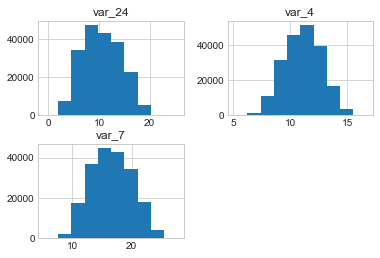

In [287]:
#Histogram before processing
data[['var_4','var_7','var_24']].hist()
plt.savefig('../data/processed/hist_before.png',bbox_inches='tight')

In [ ]:
# Get skewness and Kurtosis to analyze the shape of distribution for var
var = data.var_4
col = 'var_4'
skew_kurt_dic={}
skew_kurt_dic[col]={}
skew_kurt_dic = skew_kurt_analysis((var),'original',col, skew_kurt_dic,True)
if(not (len(data[data.var_0 == 0]) > 0) ):#If no zero value
    skew_kurt_dic = skew_kurt_analysis(np.log(var),'log',col,skew_kurt_dic,True)
else:
    skew_kurt_dic['log'] =(-1,-1)
skew_kurt_dic = skew_kurt_analysis(np.sqrt(var),'sqrt',col,skew_kurt_dic,True)
skew_kurt_dic = skew_kurt_analysis(np.cbrt(var),'cbrt',col,skew_kurt_dic,True)

plt.legend(loc='upper right')
plt.xlabel(col)
plt.savefig('../data/processed/skew_anal_%s'%col,bbox_inches='tight')

#Following gives the results for var with original values,log,sqrt,cbrt and plots histogram to see distribution
#when the curve is having pointedness in the left, then most of obs falls on right and it is said to be right skewed
#Positive skewed(right skwed) Since majority lies on right, the median(being in the middle), mean lies towrds right hand side and mean>median>mode
#negative skewed(left skwed) Now if curve is left skewed, majority obs lies in left side(tail on left side), mean<median<mode


### RESULT
log data is the best 

---------------original---------------
AxesSubplot(0.125,0.125;0.775x0.755)
Skewness :  0.08459700661643049
%%%%%Moderately symm
Kurtosis :  -0.6710274501066511
~~~~~~~~~~Flat
---------------log---------------
AxesSubplot(0.125,0.125;0.775x0.755)
Skewness :  -0.34956609209222467
%%%%%Moderately symm
Kurtosis :  -0.4503816291701672
%%%%%%%%%Moderately Bell shaped
---------------sqrt---------------
AxesSubplot(0.125,0.125;0.775x0.755)
Skewness :  -0.1272589417078805
%%%%%Moderately symm
Kurtosis :  -0.6333831565536716
~~~~~~~~~~Flat
---------------cbrt---------------
AxesSubplot(0.125,0.125;0.775x0.755)
Skewness :  -0.2000355830220948
%%%%%Moderately symm
Kurtosis :  -0.5897755295471288
~~~~~~~~~~Flat


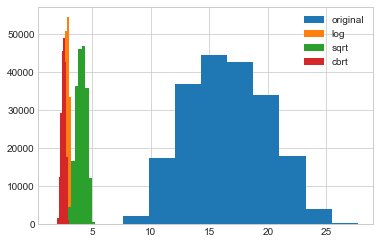

In [173]:
#Just update 'col' and 'var' and run this code to see customised results
var = data.var_7
col = 'var_7'
skew_kurt_dic={}
skew_kurt_dic[col]={}
skew_kurt_dic = skew_kurt_analysis((var),'original',col, skew_kurt_dic,True)
if(not (len(data[data.var_0 == 0]) > 0) ):#If no zero value
    skew_kurt_dic = skew_kurt_analysis(np.log(var),'log',col,skew_kurt_dic,True)
else:
    skew_kurt_dic['log'] =(-1,-1)
skew_kurt_dic = skew_kurt_analysis(np.sqrt(var),'sqrt',col,skew_kurt_dic,True)
skew_kurt_dic = skew_kurt_analysis(np.cbrt(var),'cbrt',col,skew_kurt_dic,True)

plt.legend(loc='upper right')

### RESULT
log is best

## Calculate skew and kurtosis value for each column in train and test data

Also to see, if we got distribution of variables in both train and test. If so, we can expect the model to perform better on actual field data, 
or if not, then even if we apply these transfomrations on train set, and get good accuracy, we can't be sure about the test data distribution and the results might not be accurate.

It is going to be a trial and error method.

Let us go through all the columns and get the best functions for each column , so that a better distribution can be acheived.


In [31]:
skew_kurt_dic_={}
for i,dataset in enumerate(full_data):#for both train and test data
    txt = 'train' if i ==0 else 'test'
    skew_kurt_dic_[txt] = {}
    for col in dataset.columns:
        var = full_data[i].loc[:,col]
        skew_kurt_dic_[txt][col] = {}
        skew_kurt_dic_[txt] = skew_kurt_analysis((var),'original', col , skew_kurt_dic_[txt],printverbose=False)
        if(not (len(data[data.var_0 == 0]) > 0) ):#If no zero value
            skew_kurt_dic_[txt] = skew_kurt_analysis(np.log(var),'log', col, skew_kurt_dic_[txt],printverbose=False)
        else:
            skew_kurt_dic_[txt][col]['log'] =(-1,-1)
        skew_kurt_dic_[txt] = skew_kurt_analysis(np.sqrt(var),'sqrt', col, skew_kurt_dic_[txt],printverbose=False)
        skew_kurt_dic_[txt] = skew_kurt_analysis(np.cbrt(var),'cbrt', col, skew_kurt_dic_[txt],printverbose=False)
        
    

In [32]:
skew_kurt_dic_['train']['var_7']

{'original': (0.0754784239164201, -0.648433425566517),
 'log': (-1, -1),
 'sqrt': (-0.34948946859092483, -0.3412071174602094),
 'cbrt': (-0.5256855367934122, 0.05328400815678114)}

In [33]:
#get the best function(log,sqrt,cbrt) to be applied for each col, to get a normal distribution
best_fxn(skew_kurt_dic_['train'])
best_fxn(skew_kurt_dic_['test'])

#print a slice of dic created
{k:skew_kurt_dic_['train'][k] for k in list(skew_kurt_dic_['train'].keys())[:3]}
#print({k:skew_kurt_dic_['test'][k] for k in list(skew_kurt_dic_['test'].keys())[:3]})

{'target': {'original': (2.6574381449822653, 5.061977494406788),
  'log': (-1, -1),
  'sqrt': (2.6574381449822653, 5.061977494406788),
  'cbrt': (2.6574381449822653, 5.061977494406788),
  'maxlabel': 'original'},
 'var_0': {'original': (0.20780138073870336, -0.2835965519332153),
  'log': (-1, -1),
  'sqrt': (-0.21918522581285987, -0.0039123322793002124),
  'cbrt': (-0.40897410291226804, 0.5909511830242598),
  'maxlabel': 'original'},
 'var_1': {'original': (0.04142041253809697, -0.5996319561053243),
  'log': (-1, -1),
  'sqrt': (-0.3759458656715527, -0.22128622931777286),
  'cbrt': (-0.5576387297826525, 0.28985447762310246),
  'maxlabel': 'sqrt'}}

In [34]:
#Glimpse of skew_kurt_dic
skew_kurt_dic_['train']['var_4'],skew_kurt_dic_['test']['var_92']

({'original': (-0.04483933011852527, -0.5319433646080358),
  'log': (-1, -1),
  'sqrt': (-0.4875763150857993, 0.07197242795790881),
  'cbrt': (-0.6900778225343509, 0.7676895624925821),
  'maxlabel': 'sqrt'},
 {'original': (nan, nan),
  'log': (-1, -1),
  'sqrt': (nan, nan),
  'cbrt': (nan, nan),
  'maxlabel': 'original'})

In [35]:
for txt in skew_kurt_dic_.keys():
    print('------------------%s-------'%txt)
    for col in skew_kurt_dic_[txt].keys():
        if skew_kurt_dic_[txt][col]['maxlabel'] != 'original':
            if skew_kurt_dic_[txt][col]['maxlabel'] != 'original':
                print(skew_kurt_dic_[txt][col]['maxlabel'] ,'is best for ',col)

------------------train-------
sqrt is best for  var_1
sqrt is best for  var_3
sqrt is best for  var_4
sqrt is best for  var_5
sqrt is best for  var_7
sqrt is best for  var_14
sqrt is best for  var_15
sqrt is best for  var_18
sqrt is best for  var_19
cbrt is best for  var_20
sqrt is best for  var_23
sqrt is best for  var_24
sqrt is best for  var_27
sqrt is best for  var_30
sqrt is best for  var_32
sqrt is best for  var_33
sqrt is best for  var_37
cbrt is best for  var_41
sqrt is best for  var_45
sqrt is best for  var_47
sqrt is best for  var_48
sqrt is best for  var_49
sqrt is best for  var_51
sqrt is best for  var_54
cbrt is best for  var_55
sqrt is best for  var_59
sqrt is best for  var_61
sqrt is best for  var_70
sqrt is best for  var_71
sqrt is best for  var_73
sqrt is best for  var_77
sqrt is best for  var_79
sqrt is best for  var_82
sqrt is best for  var_84
sqrt is best for  var_85
sqrt is best for  var_90
sqrt is best for  var_91
sqrt is best for  var_92
sqrt is best for  var_94

### RESULT
We see that the distribution of variables in train and test is different, 

For e.g. var_3 in train dataset has normal(bell shaped) distributon , but in test data its skewed.

Had it been the same, we could apply the suggested functions on both train and test in same fashion(same order), so that the results dont vary on actual test data.

CONCLUSION:
Either apply the same set of functions on both train and test 
or don't apply at all(If we dont do anything, then the corr is very less and model score is also lesser)

Let's try option 1 here

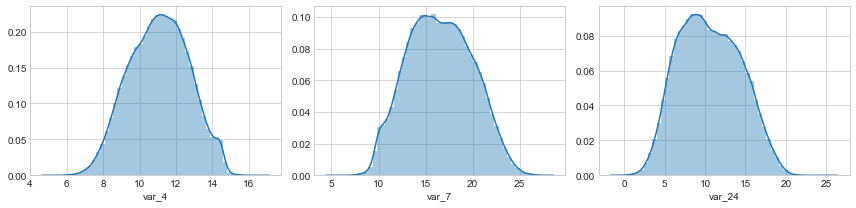

In [250]:
#Let us record old value for comaprisons
df = data[['var_4','var_7','var_24']]
fig,axes = plt.subplots(figsize=(12,3) , ncols = len(df.columns))
for ax,col in zip(axes,df.columns):
    sb.distplot(df[col],ax=ax)
    plt.tight_layout()
plt.savefig('../data/processed/dis_plot_.png',bbox_inches='tight')

# Apply suggested functions to respective columns

In [36]:
# block of code to apply suggested functions(different) for both train and test


print_count = 0 #Flag to print, just prints first 10 entries from this loop, to have a glimpse
for txt in skew_kurt_dic_.keys():
    #uncomment below line, if diffrernt labels needs to be applied
    #i = 0 if txt == 'train' else 1 #index for full_data
    i = 0 #use train data labels to be applied on both train and test datasets
    for col in skew_kurt_dic_[txt].keys():
        print_count += 1
        if col == 'target':#dependent/target variable
            continue#to next column(skip this)
        if skew_kurt_dic_[txt][col]['maxlabel'] == 'sqrt':
            print('%% sqrt to be applied for ',col)
            full_data[i].loc[:,col] = np.sqrt(full_data[i].loc[:,col])
        elif skew_kurt_dic_[txt][col]['maxlabel'] == 'cbrt':
            print('%% cbrt to be applied for ',col)
            full_data[i].loc[:,col] = np.cbrt(full_data[i].loc[:,col])

        elif skew_kurt_dic_[txt][col]['maxlabel'] == 'log':
            print('%% log to be applied for ',col)
            full_data[i].loc[:,col] = np.log(full_data[i].loc[:,col])
        else:
            print('!! original is the best for ',col)        

!! original is the best for  var_0
%% sqrt to be applied for  var_1
!! original is the best for  var_2
%% sqrt to be applied for  var_3
%% sqrt to be applied for  var_4
%% sqrt to be applied for  var_5
!! original is the best for  var_6
%% sqrt to be applied for  var_7
!! original is the best for  var_8
!! original is the best for  var_9
!! original is the best for  var_10
!! original is the best for  var_11
!! original is the best for  var_12
!! original is the best for  var_13
%% sqrt to be applied for  var_14
%% sqrt to be applied for  var_15
!! original is the best for  var_16
!! original is the best for  var_17
%% sqrt to be applied for  var_18
%% sqrt to be applied for  var_19
%% cbrt to be applied for  var_20
!! original is the best for  var_21
!! original is the best for  var_22
%% sqrt to be applied for  var_23
%% sqrt to be applied for  var_24
!! original is the best for  var_25
!! original is the best for  var_26
%% sqrt to be applied for  var_27
!! original is the best for 

In [316]:
data.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,2.438924,-9.2834,5.1187,2.924591,-4.9200,...,4.4354,3.9642,3.1364,1.6910,2.918997,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,2.514643,7.0433,5.6208,2.805407,3.1468,...,7.6421,7.7214,2.5837,10.9516,2.736346,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,2.359202,-9.0837,6.9427,2.682083,-4.9193,...,2.9057,9.7905,1.6704,1.6858,3.072888,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,2.532474,-1.8361,5.8428,2.703038,-5.8609,...,4.4666,4.7433,0.7178,1.4214,3.137002,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,2.507744,2.4486,5.9405,2.957584,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,2.586831,-1.5121,3.9267,9.5031,17.9974,-8.8104


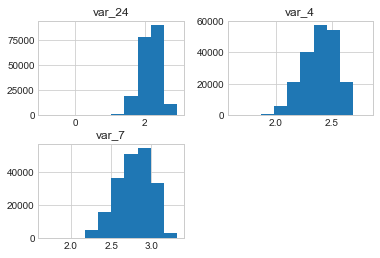

In [252]:
#Histogram after processing
data[['var_4','var_7','var_24']].hist()
plt.savefig('../data/processed/hist_after.png',bbox_inches='tight')

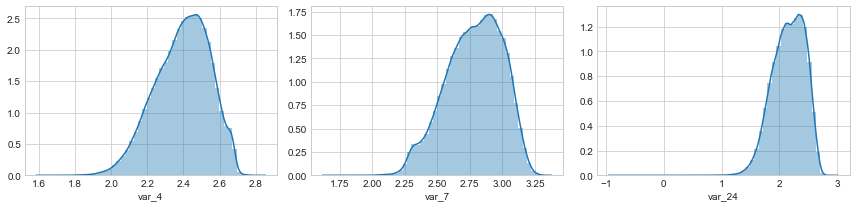

In [253]:
#Let us record new ones
df = data[['var_4','var_7','var_24']]
fig,axes = plt.subplots(figsize=(12,3) , ncols = len(df.columns))
for ax,col in zip(axes,df.columns):
    sb.distplot(df[col],ax=ax)
    plt.tight_layout()
plt.savefig('../data/processed/dis_plot_after.png',bbox_inches='tight')

## That looks nice
Now the columns are relatively closer to a normal distribution

# 3. Bi-variate analysis

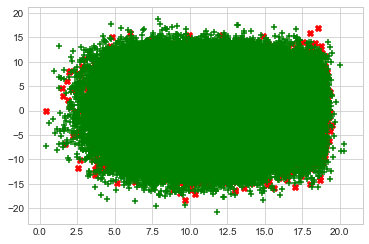

In [161]:
#Let us plot scatterplots to see how our decision boundary going to be
df0 = data[data['target'] == 0]
df1 = data[data['target'] == 1]

plt.scatter(df1['var_0'], df1.var_10, marker='X',color='red')
plt.scatter(df0['var_0'], df0.var_10, marker='+',color='green')
plt.savefig('../data/processed/scatter_var0.png',bbox_inches='tight')

### They are overlapping, indicating 
it is difficult to draw a boundary b/w them, linear model would not do well, since a line or plane is not going to accurately divide the two classes clearly.

## let us chek if our iv have linear reation exists or not?

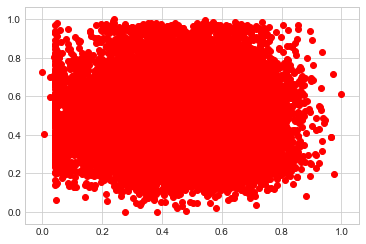

In [9]:
plt.scatter(data['var_12'],data['var_2'],color='red')


### RESULT:
the relation is not linear, but curvier(all over the place)

# 4. See linear relationship b/w variables
Plot the scattermatrix

In [317]:
# we need to plot the scatter plots, but we will go ahead with most correlated features only
corr = data.corr()


In [318]:
#Top 10 corr(pos and negative both included, just magnitude is considered)
abs(corr['target']).nlargest(10)

target     1.000000
var_81     0.080917
var_139    0.074080
var_12     0.069489
var_6      0.066731
var_110    0.064275
var_146    0.063644
var_53     0.063399
var_26     0.062422
var_76     0.061917
Name: target, dtype: float64

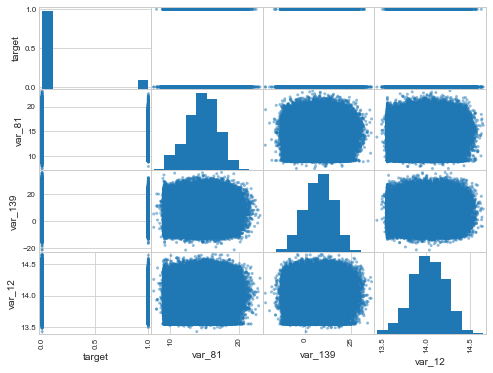

In [300]:
#Take the top most corr features(pos or neg) and plot
attributes = ["target","var_81","var_139","var_12"]
scatter_matrix(data[attributes], figsize=(8,6))
plt.savefig('../data/processed/scatter_mat_before.png',bbox_inches='tight')

### RESULT:
The values are very dispersed and not very strongly correlated with the target variable. Not much of collinearity of DV with IV

# 5. Outlier analysis for continous variables

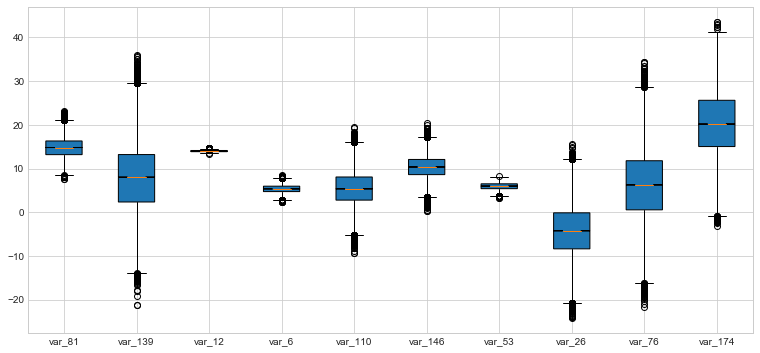

In [303]:
# Take a subset of most correlated features and plot, since original data is huge
larg_10 = abs(corr['target']).nlargest(11)

train_top10 = data[larg_10.index.values]#subset of top 10
train_top10 = train_top10.drop(['target'],axis=1)
plot = []
for i in train_top10.columns:
    plot.append(list(train_top10.loc[:,i]))
plt.boxplot(plot, notch = 'True', patch_artist= True, labels=train_top10.columns)
rcParams['figure.figsize']=20,6
plt.savefig('../data/processed/boxplot_before.png',bbox_inches='tight')

In [304]:
data.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,2.438924,-9.2834,5.1187,2.924591,-4.9200,...,4.4354,3.9642,3.1364,1.6910,2.918997,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,2.514643,7.0433,5.6208,2.805407,3.1468,...,7.6421,7.7214,2.5837,10.9516,2.736346,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,2.359202,-9.0837,6.9427,2.682083,-4.9193,...,2.9057,9.7905,1.6704,1.6858,3.072888,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,2.532474,-1.8361,5.8428,2.703038,-5.8609,...,4.4666,4.7433,0.7178,1.4214,3.137002,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,2.507744,2.4486,5.9405,2.957584,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,2.586831,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [319]:
#Replace outlier with mean in both train and test dataframes

continous_names = [ x for x in data.columns if x not in ['target']]
outliers =[]
for i in continous_names:
    q75,q25 = np.percentile(data.loc[:,i],[75,25])
    iqr = q75 - q25
    min = q25 - (iqr* 1.5)#lower fence
    max = q75 + (iqr* 1.5)#upper fence
   
    
    print('-----Thes will be droppped for col :',i,'\n',data[data.loc[:,i] >max].head(2))
    print(min,max)
    outliers.append('per outliers for %s is %s'%(i, ( (len(data[data.loc[:,i] > max])/len(data)) )*100 ))
    outliers.append('per outliers for %s is %s'%(i, ( (len(data[data.loc[:,i] < min])/len(data)) )*100 ))
    data.loc[data.loc[:,i]<min,i] = data.loc[:,i].mean()#Replace with mean
    data.loc[data.loc[:,i]>max,i] = data.loc[:,i].mean()
    #train_df = train_df.drop(train_df[train_df.loc[:,i] > max].index) #for dropping
    test.loc[test.loc[:,i]<min,i] = test.loc[:,i].mean()#Replace with mean
    test.loc[test.loc[:,i]>max,i] = test.loc[:,i].mean()

-----Thes will be droppped for col : var_0 
        target    var_0   var_1   var_2   var_3     var_4   var_5   var_6  \
1901        0  19.2893 -6.6190  9.2233  8.1546  2.262221  0.4922  5.4389   
25113       1  19.3259  2.3242  7.2635  7.4320  2.326468 -0.9305  5.4321   

          var_7   var_8  ...  var_190  var_191  var_192  var_193   var_194  \
1901   2.608812  4.1526  ...  10.8734   3.1431   4.9796   5.5966  2.986797   
25113  3.098704  0.7752  ...   3.6115   2.9789   2.0681   3.5961  2.942817   

       var_195  var_196  var_197  var_198  var_199  
1901    0.8586   8.8525   7.5988  16.0018   8.3490  
25113  -0.8246   6.4138   9.0963  13.5367   6.5478  

[2 rows x 201 columns]
1.9973250000000018 19.214725
-----Thes will be droppped for col : var_1 
 Empty DataFrame
Columns: [target, var_0, var_1, var_2, var_3, var_4, var_5, var_6, var_7, var_8, var_9, var_10, var_11, var_12, var_13, var_14, var_15, var_16, var_17, var_18, var_19, var_20, var_21, var_22, var_23, var_24, var_25, va

       target    var_0   var_1    var_2   var_3     var_4    var_5   var_6  \
1142       0  13.2190 -0.3674   9.1503  7.5284  2.508517  -0.8075  6.6443   
4421       0   8.4748 -3.2147  14.9410  8.7766  2.245189 -17.0386  4.6961   

         var_7   var_8  ...  var_190  var_191  var_192  var_193   var_194  \
1142  2.797452  5.0441  ...   0.2924   9.6674  -0.5568   3.8096  2.969209   
4421  2.899238 -2.8352  ...   1.4684   8.8852  -0.1753   3.2631  2.854842   

      var_195  var_196  var_197  var_198  var_199  
1142   0.8631  -7.4444   8.6813   17.191   3.1951  
4421  -0.5993  -9.8560   6.7171   19.583  -6.9400  

[2 rows x 201 columns]
-15.561762500000002 16.349737500000003
-----Thes will be droppped for col : var_11 
       target   var_0   var_1   var_2   var_3     var_4    var_5   var_6  \
1287       0  9.7614  2.8819  8.5164  7.0085  2.016528 -10.7206  5.5842   
3586       0  9.6339 -5.9010  9.1861  5.2645  2.588162 -13.0643  6.1417   

         var_7   var_8  ...  var_190  var_19

-----Thes will be droppped for col : var_21 
       target   var_0   var_1    var_2   var_3     var_4    var_5   var_6  \
870        0  7.8341 -6.0201   9.8943  7.1007  2.381775  -4.2071  6.3250   
1545       0  9.4054 -3.9924  16.2365  6.3111  2.113541 -15.5759  5.6549   

         var_7   var_8  ...  var_190  var_191  var_192  var_193   var_194  \
870   2.776699 -0.4527  ...   8.2969  10.1202   0.9484   5.0918  2.703078   
1545  2.258194 -4.7551  ...   4.3036   5.6125   0.5567   6.7035  2.692077   

      var_195  var_196  var_197  var_198  var_199  
870   -0.5252   2.0332   9.0268  14.3728  -8.1480  
1545   0.4529   1.7201   8.7506  16.2218   2.0891  

[2 rows x 201 columns]
-5.75607500000001 40.39612500000001
-----Thes will be droppped for col : var_22 
       target    var_0   var_1    var_2   var_3     var_4    var_5   var_6  \
1134       0   6.9098  0.3245  10.8428  5.5112  2.620704   2.0510  4.0345   
2248       0  10.4675 -3.5245  11.9240  5.6927  2.573718 -12.9291  5.7343   


-----Thes will be droppped for col : var_32 
 Empty DataFrame
Columns: [target, var_0, var_1, var_2, var_3, var_4, var_5, var_6, var_7, var_8, var_9, var_10, var_11, var_12, var_13, var_14, var_15, var_16, var_17, var_18, var_19, var_20, var_21, var_22, var_23, var_24, var_25, var_26, var_27, var_28, var_29, var_30, var_31, var_32, var_33, var_34, var_35, var_36, var_37, var_38, var_39, var_40, var_41, var_42, var_43, var_44, var_45, var_46, var_47, var_48, var_49, var_50, var_51, var_52, var_53, var_54, var_55, var_56, var_57, var_58, var_59, var_60, var_61, var_62, var_63, var_64, var_65, var_66, var_67, var_68, var_69, var_70, var_71, var_72, var_73, var_74, var_75, var_76, var_77, var_78, var_79, var_80, var_81, var_82, var_83, var_84, var_85, var_86, var_87, var_88, var_89, var_90, var_91, var_92, var_93, var_94, var_95, var_96, var_97, var_98, ...]
Index: []

[0 rows x 201 columns]
-8.4558375 7.4240625
-----Thes will be droppped for col : var_33 
 Empty DataFrame
Columns: [target

-----Thes will be droppped for col : var_43 
        target    var_0   var_1    var_2   var_3     var_4   var_5   var_6  \
541         0  16.0108 -1.0694  12.6350  5.1256  2.434709  0.6848  5.4884   
34174       0   7.6407 -2.3559  12.6189  5.3709  2.222123  0.8161  4.6679   

          var_7   var_8  ...  var_190  var_191  var_192  var_193   var_194  \
541    2.437553 -5.8316  ...  14.5158   9.7648   1.5818   4.5355  2.846983   
34174  2.918041 -0.5565  ...  -4.3495   7.9928   3.0826   5.6195  3.080763   

       var_195  var_196  var_197  var_198  var_199  
541     0.6783  -1.2133   8.5208  15.8664  -8.5728  
34174   3.4015   4.5673   9.3530  13.9534  11.8938  

[2 rows x 201 columns]
10.6526 12.495800000000003
-----Thes will be droppped for col : var_44 
      target    var_0   var_1    var_2   var_3    var_4    var_5   var_6  \
595       0  10.4624 -6.2926  11.8308  5.1565  2.18379 -12.6228  5.4036   
895       0  13.7722  6.3564  12.4972  8.3620  2.41230   2.1829  6.7236   

     

-----Thes will be droppped for col : var_58 
      target    var_0   var_1    var_2   var_3     var_4    var_5   var_6  \
201       0  14.7089  4.9614  11.9933  6.2527  2.607618  -4.0432  6.0295   
439       0   7.7861 -2.4155   8.8196  6.7885  2.541712 -17.3400  4.2501   

        var_7   var_8  ...  var_190  var_191  var_192  var_193   var_194  \
201  2.829837  0.8957  ...   2.3631  10.3143  -1.1531  -2.6638  3.014053   
439  2.238676 -1.8053  ...   6.6602   5.3743   1.8612   9.0756  2.841024   

     var_195  var_196  var_197  var_198  var_199  
201  -1.9929   7.3585   8.2798  17.7571  -1.8832  
439   2.8404  -2.2069   8.6941  12.3746 -13.2637  

[2 rows x 201 columns]
-8.855799999999999 15.248999999999999
-----Thes will be droppped for col : var_59 
        target    var_0   var_1    var_2   var_3     var_4   var_5   var_6  \
19924       0   9.7353 -7.0514   8.3438  6.6275  2.571268  1.2004  5.3293   
21842       0  13.3534 -3.4249  16.0256  9.0681  2.337634 -0.5650  6.6244   

   

       target  var_0   var_1    var_2   var_3     var_4    var_5   var_6  \
1218       1  9.050  0.3014  11.2326  4.2288  2.193562 -14.0144  4.6312   
1692       0  8.826  2.2888  11.4764  8.3667  2.419452 -10.3628  6.0174   

         var_7   var_8  ...  var_190  var_191  var_192  var_193   var_194  \
1218  3.085728  3.4927  ...   3.8121   6.2341   4.1610   1.9530  3.052009   
1692  3.157630  2.2098  ...  -0.2568  10.1454   3.1572   6.4452  3.043789   

      var_195  var_196  var_197  var_198  var_199  
1218  -1.2831   3.5474   8.7926  17.6257   9.7901  
1692  -0.5463  -1.5217   8.4590  14.2959 -19.1385  

[2 rows x 201 columns]
-10.7588 12.0724
-----Thes will be droppped for col : var_73 
       target   var_0   var_1    var_2   var_3     var_4    var_5   var_6  \
1030       0  7.4871  2.6655   9.8138  8.4646  2.376913 -16.6889  6.0293   
8991       1  9.0514 -4.6210  12.7906  5.8260  2.054342  -2.1025  4.5472   

         var_7   var_8  ...  var_190  var_191  var_192  var_193   var

-----Thes will be droppped for col : var_86 
       target    var_0   var_1    var_2   var_3     var_4   var_5   var_6  \
2687       0  12.1478 -0.1486  13.4172  6.3509  2.398004  0.2364  4.7923   
3118       0   8.2295 -2.8973   7.7493  4.9626  2.485598 -0.2769  6.5221   

         var_7   var_8  ...  var_190  var_191  var_192  var_193   var_194  \
2687  3.154209 -2.9048  ...   6.9711  10.0351   0.7381  -3.5812  2.573307   
3118  2.540097 -3.6302  ...  -1.8648   9.8826   1.5843   5.8237  3.018457   

      var_195  var_196  var_197  var_198  var_199  
2687  -2.2981  -0.0523   8.4124  13.4506  14.0910  
3118  -0.9972   0.0681   7.8433  12.1116   9.8181  

[2 rows x 201 columns]
-15.718687500000001 27.2846125
-----Thes will be droppped for col : var_87 
       target    var_0   var_1    var_2   var_3     var_4    var_5   var_6  \
414        0  12.5973  2.9705  11.2044  5.0467  2.532704   3.5875  4.5810   
1740       0   7.8745  1.4242  10.1980  9.1988  2.538479 -13.3877  7.3915   

    

-----Thes will be droppped for col : var_98 
       target    var_0   var_1    var_2   var_3     var_4   var_5   var_6  \
14         0  13.8080  5.0514  17.2611  8.5120  2.553476 -9.1622  5.7327   
1413       0  11.8334  1.1490  11.1045  5.1501  2.356846  7.5144  5.3338   

         var_7   var_8  ...  var_190  var_191  var_192  var_193   var_194  \
14    3.046981 -4.5117  ...   1.0740   8.3220   3.2619   1.6738  2.861040   
1413  3.041790  8.4394  ...  10.1183  11.3127   1.7281   5.7580  3.066815   

      var_195  var_196  var_197  var_198  var_199  
14    -0.0257  -3.5323   9.3439  24.4479  -5.1110  
1413  -0.6612  10.9669  10.1692  12.7113   5.8111  

[2 rows x 201 columns]
-0.2221624999999996 3.7507374999999996
-----Thes will be droppped for col : var_99 
        target    var_0   var_1    var_2   var_3     var_4   var_5   var_6  \
32382       0   8.9002 -3.0174  13.7154  7.7958  2.414404 -0.9733  4.6468   
33829       0  11.5212 -3.4232   8.3816  6.9600  2.563910 -4.2539  4.7485 

[0 rows x 201 columns]
13.704550000000001 14.756150000000002
-----Thes will be droppped for col : var_109 
 Empty DataFrame
Columns: [target, var_0, var_1, var_2, var_3, var_4, var_5, var_6, var_7, var_8, var_9, var_10, var_11, var_12, var_13, var_14, var_15, var_16, var_17, var_18, var_19, var_20, var_21, var_22, var_23, var_24, var_25, var_26, var_27, var_28, var_29, var_30, var_31, var_32, var_33, var_34, var_35, var_36, var_37, var_38, var_39, var_40, var_41, var_42, var_43, var_44, var_45, var_46, var_47, var_48, var_49, var_50, var_51, var_52, var_53, var_54, var_55, var_56, var_57, var_58, var_59, var_60, var_61, var_62, var_63, var_64, var_65, var_66, var_67, var_68, var_69, var_70, var_71, var_72, var_73, var_74, var_75, var_76, var_77, var_78, var_79, var_80, var_81, var_82, var_83, var_84, var_85, var_86, var_87, var_88, var_89, var_90, var_91, var_92, var_93, var_94, var_95, var_96, var_97, var_98, ...]
Index: []

[0 rows x 201 columns]
1.9865092762939123 3.2813427675126317

-----Thes will be droppped for col : var_122 
        target    var_0   var_1    var_2   var_3     var_4   var_5   var_6  \
3004        0   8.1526 -2.4453  13.7928  3.9833  2.604473 -6.2366  6.2007   
19402       0  10.3552 -3.4984  14.7332  4.8540  2.522780 -1.9949  4.6005   

          var_7   var_8  ...  var_190  var_191  var_192  var_193   var_194  \
3004   2.733763 -0.4209  ...   7.6883   5.5694  -0.2103   2.3623  2.882513   
19402  3.180027  3.8840  ...   4.1909  14.7752   1.2419   9.0347  3.118720   

       var_195  var_196  var_197  var_198  var_199  
3004   -1.3264   3.3487   8.3663  16.4307  -4.4948  
19402   1.5113   5.4699   7.8324  21.3061   1.9062  

[2 rows x 201 columns]
-14.050550000000001 16.57705
-----Thes will be droppped for col : var_123 
        target    var_0   var_1    var_2    var_3     var_4    var_5   var_6  \
32352       0   5.8230 -7.2732   5.8846   5.8847  2.354285 -14.7358  6.0744   
65232       0  12.3908 -3.5576  10.2850  10.0434  2.315077  11.0322  

-----Thes will be droppped for col : var_133 
       target    var_0   var_1    var_2   var_3     var_4    var_5   var_6  \
42         0   9.0143 -6.9861  15.3908  9.0216  2.327717 -15.1629  5.2685   
2412       0  16.5665 -6.5156  11.9282  4.9957  2.522869  -8.5609  7.2283   

         var_7   var_8  ...  var_190  var_191  var_192  var_193   var_194  \
42    2.807111  3.3576  ...   9.9122   7.8639   0.5773   4.6717  2.971829   
2412  2.972883 -4.0832  ...   3.1201   9.8350   4.0202   8.4009  2.888854   

      var_195  var_196  var_197  var_198  var_199  
42     0.3066   5.7188   8.2301  10.8854  -5.8121  
2412  -0.6234   4.4143   8.7016  15.4093  12.8977  

[2 rows x 201 columns]
5.752549999999999 7.861750000000001
-----Thes will be droppped for col : var_134 
 Empty DataFrame
Columns: [target, var_0, var_1, var_2, var_3, var_4, var_5, var_6, var_7, var_8, var_9, var_10, var_11, var_12, var_13, var_14, var_15, var_16, var_17, var_18, var_19, var_20, var_21, var_22, var_23, var_24, va

-----Thes will be droppped for col : var_146 
      target    var_0   var_1    var_2   var_3     var_4    var_5   var_6  \
140       0  15.3041  2.4667  14.8695  9.9017  2.286710 -11.0875  5.9374   
180       0  13.1245 -9.1658   9.8201  4.9837  2.323955 -14.4521  4.5780   

        var_7   var_8  ...  var_190  var_191  var_192  var_193   var_194  \
140  3.004325  3.9400  ...  -1.0242   7.5738   2.6147  -2.6058  3.021882   
180  2.481509 -2.8204  ...   8.6457   8.5006  -0.9075   1.4677  3.020279   

     var_195  var_196  var_197  var_198  var_199  
140   1.4003   4.6532   9.1123  14.2411 -17.0844  
180   1.2467   6.5371   9.9652  20.7511 -16.9045  

[2 rows x 201 columns]
3.4474124999999987 17.312712500000004
-----Thes will be droppped for col : var_147 
       target   var_0   var_1    var_2   var_3     var_4   var_5   var_6  \
1143       0  8.4162 -7.6751  12.2440  4.9126  2.269183 -7.2032  5.6511   
1366       0  9.8077  4.7286  15.7239  8.0646  2.381424 -5.0071  5.4759   

       

-----Thes will be droppped for col : var_158 
        target   var_0   var_1    var_2   var_3     var_4    var_5   var_6  \
17361       0  5.6596 -3.5896  12.4019  4.0601  2.450539  -8.5822  4.6095   
45909       0  7.5721  0.5051  12.5022  8.8840  2.285754 -16.8290  5.5722   

          var_7   var_8  ...  var_190  var_191  var_192  var_193   var_194  \
17361  2.867058  4.5465  ...   0.6842   3.5651  -1.2681   1.7625  2.906825   
45909  2.807395  2.4412  ...  11.7006   6.0160   1.6071   9.9139  3.010611   

       var_195  var_196  var_197  var_198  var_199  
17361  -0.9182  -2.9526   6.6066  17.8535  -6.3125  
45909   1.1984  -3.6423   8.8954   8.4071  12.8878  

[2 rows x 201 columns]
-5.539987499999997 41.52451249999999
-----Thes will be droppped for col : var_159 
       target    var_0   var_1    var_2   var_3     var_4    var_5   var_6  \
1714       1  13.7351 -4.7083  15.5164  4.5673  2.187006   1.5157  6.1508   
3958       0  12.1132 -6.8407   8.1538  5.8500  2.483389 -13.1580

[2 rows x 201 columns]
-16.236075 14.472525
-----Thes will be droppped for col : var_172 
      target   var_0   var_1    var_2   var_3     var_4    var_5   var_6  \
413       0   5.937 -2.7793  10.5183  9.6073  2.606564   1.1257  5.7890   
910       0  14.203 -3.3531  11.3766  9.6660  2.507068 -10.8164  4.5136   

        var_7   var_8  ...  var_190  var_191  var_192  var_193  var_194  \
413  3.001292 -4.7711  ...  -2.6096   5.2904   2.5536   2.1277  3.01653   
910  2.631277  1.5623  ...  -0.3998   5.0212   2.9254  -4.5909  2.41213   

     var_195  var_196  var_197  var_198  var_199  
413  -2.3392   0.3277    8.779  14.6937  -7.5769  
910   2.1915  -8.5594   10.674  10.8765  12.5892  

[2 rows x 201 columns]
-4.5321500000000015 44.17165
-----Thes will be droppped for col : var_173 
       target    var_0   var_1    var_2   var_3     var_4   var_5   var_6  \
4243       0   8.9678 -7.0980   8.9835  6.8913  2.433368 -4.5280  5.6926   
7653       0  11.1503  3.2229  10.4165  7.5757  2.27

        target    var_0   var_1    var_2   var_3     var_4   var_5   var_6  \
5989        1  10.2178 -2.4078   7.7971  4.6590  2.581723 -6.1358  4.9019   
21312       0  10.6253  6.8608  11.0699  8.3978  2.575676 -1.5485  5.6017   

          var_7   var_8  ...  var_190  var_191  var_192  var_193   var_194  \
5989   2.723766  1.9879  ...   3.2566  11.0081   2.8191   6.8987  2.814798   
21312  2.517616  1.0860  ...   1.0301   6.7675   2.3895   6.8205  2.535742   

       var_195  var_196  var_197  var_198  var_199  
5989   -1.1520   1.0077   7.0366  15.9610   8.1931  
21312  -1.9497   4.4845   9.3168  10.0126   1.0971  

[2 rows x 201 columns]
-15.025975000000003 40.145425
-----Thes will be droppped for col : var_185 
       target    var_0   var_1    var_2   var_3     var_4    var_5   var_6  \
581        0  11.3996 -2.7258  14.2189  7.5132  2.304014   5.6841  4.9744   
1284       0  15.4300  2.2009   8.9246  6.7386  2.490284 -14.9916  6.2431   

         var_7   var_8  ...  var_190  va

-----Thes will be droppped for col : var_197 
       target    var_0   var_1   var_2   var_3     var_4   var_5   var_6  \
742        0  12.9788 -0.8313  9.3993  6.5823  2.294684 -1.1951  5.9384   
3210       0   8.0286 -7.5038  9.0715  8.8234  2.230111  3.0890  5.8030   

         var_7   var_8  ...  var_190  var_191  var_192  var_193   var_194  \
742   2.605316  1.6139  ...  -1.6181  10.0279   0.7339   6.5918  2.814294   
3210  2.564603 -0.2644  ...   4.8693   5.0130   0.5967   6.5621  2.458631   

      var_195  var_196  var_197  var_198  var_199  
742   -1.2481  -0.9438  11.7012  13.3069   6.9202  
3210  -1.0055   6.0411  11.8439  15.1405 -22.4042  

[2 rows x 201 columns]
6.2420500000000025 11.604049999999997
-----Thes will be droppped for col : var_198 
       target    var_0   var_1    var_2   var_3     var_4   var_5   var_6  \
14         0  13.8080  5.0514  17.2611  8.5120  2.553476 -9.1622  5.7327   
2314       0   7.1273 -6.7127  12.2990  6.4572  2.260679 -4.5721  5.0607   

 

In [320]:
full_data[0].head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,2.438924,-9.2834,5.1187,2.924591,-4.9200,...,4.4354,3.9642,3.1364,1.6910,2.918997,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,2.514643,7.0433,5.6208,2.805407,3.1468,...,7.6421,7.7214,2.5837,10.9516,2.736346,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,2.359202,-9.0837,6.9427,2.682083,-4.9193,...,2.9057,9.7905,1.6704,1.6858,3.072888,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,2.532474,-1.8361,5.8428,2.703038,-5.8609,...,4.4666,4.7433,0.7178,1.4214,3.137002,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,2.507744,2.4486,5.9405,2.957584,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,2.586831,-1.5121,3.9267,9.5031,17.9974,-8.8104


# 6.  Let's see our target class distribution

No Transaction : 179902 
Transaction : 20098
Ratio Imbalanced


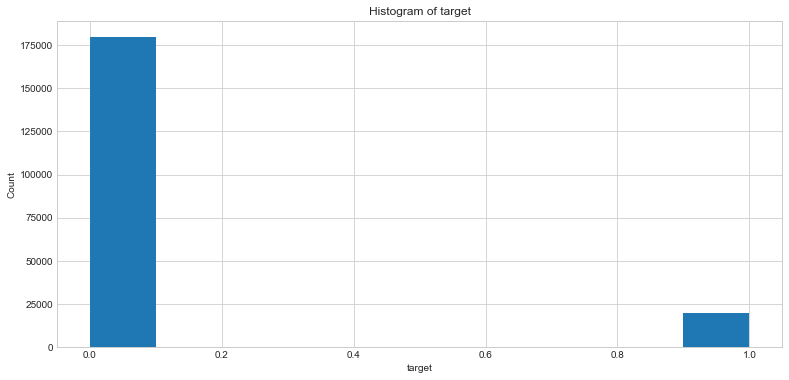

In [199]:
data['target'].hist()
print('No Transaction :',len(data[data['target'] == 0]),'\nTransaction :',len(data[data['target'] == 1]))
print('Ratio %s'%('Balanced' if len(data[data['target'] == 0])/len(data[data['target'] == 1]) <2 else 'Imbalanced'))
plt.xlabel('target') 
plt.ylabel('Count')
plt.title('Histogram of target')
plt.savefig('../data/processed/hist_target.png',bbox_inches='tight')

## Analysis:
Negative case : target = 0 means customer will not make a transaction in future

Positive case : target = 1 means customer will make a transaction in future


Data is imbalanced, need to use techiniques:
-- undersampling - randomly select a sub-sample from negative class to make equal to positive class
--oversampling  - SMOTE to synthesise positive cases 

### which one to choose?
we need to see deviation is higher in which class.
If we see that col say x1 ia having a very less standard deviation, which means the range of values it can take are less, then we can do undersampling and we will not loose on significant data, since the variation is less and lesser sample size also will cover say 90% of the data. So in this case undersampling serves the cause

Bt of we see the sd for x1 is more, the distribution of values is widely spread, then if we take an undersample, we will loose on data since x1 is widely distrubuted across the samples, so here oversampling is needed.

cons of oversampling:
If we have say 90-10 in negative-positive cases, then our predictions are actually expected to be more in negative cases, in actual data or even in synthetic minority oversampling techiniq(SMOTE), but what happens in reality is that if prop is made to 50-50, then the predictions of negative and positive classes also becomes more balanced, which doesnt represent the real scenario

cons of undersampling:
we may loose on signifcant information from the samples which we didn't include in the test , if deviation in the variable is more

In [209]:
def plot_dist(var,plot=True):
    
    m = var.mean()
    sd = var.std()
    if plot == True:
        sb.distplot(var)
        plt.plot([m,m,m],[0,1,2],'r',label = 'mean')
        plt.plot([m+sd,m+sd,m+sd],[0,1,2],'g',label = '68%')
        plt.plot([m-sd,m-sd,m-sd],[0,1,2],'g')
        plt.plot([m+2*sd,m+2*sd,m+2*sd],[0,1,2],'y',label = '95%')
        plt.plot([m-2*sd,m-2*sd,m-2*sd],[0,1,2],'y')
        plt.legend()
    return m-2*sd,m-sd,m+sd,m+2*sd

def z_score(data,target):
    confidence_interval = {}
    for col in data.columns:
        if col == target:
            continue
        
        x = data.loc[:,col]
        std_error = x.std()/np.sqrt(len(data))
        #print(col,x.mean(),x.std())
        cum_z_score = t.ppf((1+0.95)/2., n-1)
        #print(z)
        confidence_interval[col] = [x.mean()+cum_z_score*std_error, x.mean()-cum_z_score*std_error]
    return confidence_interval

In [207]:
x=data.var_0
upp = m+1*sd
low = m-1*sd
low,upp,abs(len(x[x<upp])/len(data) - len(x[x>low])/len(data))*100

(0.3825087021105885, 0.7035311641556877, 0.40999999999999925)

In [229]:
#confirmation
sum(x.between(0.2,0.86))/len(data)


0.95805

## Lets check the distribution range for var_0

(0.22199747108803886, 0.8640423951782374)

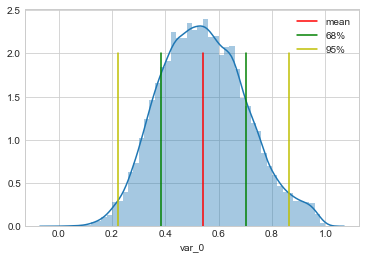

In [210]:
min_95_per , _,_,max_95_per = plot_dist(data.var_0)
min_95_per,max_95_per
# That looks quite densely distributed

In [228]:
count = 0 
for col in data.columns:
        
        if col == 'target':
            continue
        min_95_per , _,_,max_95_per = plot_dist(data.loc[:,col],plot= False)
        if max_95_per-min_95_per >0.5:
            #print(col,data.loc[:,col].std())
            count += 1
count/len(data.columns)

0.8159203980099502

### RESULT:
81 % of variables(predictor) are having standard deviation very less, so undersampling also can be done

## i. undersampling

In [226]:
from imblearn.under_sampling import NearMiss

iv = data.drop(['target'],axis=1)
dv = data['target']
nm = NearMiss(random_state=42)
iv_res,dv_res = nm.fit_sample(iv,dv) #basically draws random sample from the majority class and comes down to count of min class
iv_oversamp = pd.DataFrame(data=iv_res,columns=iv.columns.values)
dv_oversamp = pd.DataFrame(data=dv_res,columns=dv.to_frame().columns.values)
    
train_under = pd.concat([iv_oversamp,dv_oversamp],axis=1)
train_under.shape

(4020, 201)

In [227]:
# original data ,undersample data
print(data['target'].value_counts())
#new undersample
train_under.target.value_counts()

0    17990
1     2010
Name: target, dtype: int64


1    2010
0    2010
Name: target, dtype: int64

In [236]:
iv = train_under.drop(['target'], axis =1).values
dv = train_under['target'].values



print('RandomForestClasssifier-------')
rf_avg_score,rf_auc,fpr,tpr = get_oof(train_under, rf, iv, dv)
print('Average RandomForestClasssifier score', rf_avg_score)

print('SVM-----------------')
svm_avg_score , svm_auc,fpr,tpr = -1,[],0,0#get_oof(train_under, svm, iv, dv)
#SVM almost does while calculating the distances.
#Time comlexity becomes no_samples^2 * no_features for eac feature it needs to calculates svm,so skipping SVm
print('Average SVM score', svm_avg_score)

print('NAIVE BAYES-----------------')
nb_avg_score,nb_auc,fpr,tpr = get_oof(train_under, nb, iv, dv)
print('Average nb score', nb_avg_score)

print('logisticRegression--------')
lr_avg_score, lr_auc,fpr,tpr= get_oof(train_under, lr, iv, dv)
print('Average lr score', lr_avg_score)

print("Training complete")
result = {'RandomForestClasssifier':(rf_avg_score,rf_auc,fpr,tpr),
         'svm':(svm_avg_score,svm_auc,fpr,tpr),
         'naive bayes': (nb_avg_score,nb_auc,fpr,tpr),
         'LogisticRegression':(lr_avg_score,lr_auc,fpr,tpr)}
upd_result = dict((val[0],key) for key,val in result.items())#create a dic by rev 'result' pairs and extracting key with max value
print('%%%%%%%%%% BEST model :',upd_result[get_max(result)] ,'-----score',get_max(result))
      


RandomForestClasssifier-------
0.5572139303482587
0.5360696517412935
0.6703980099502488
0.3345771144278607
0.35199004975124376
Average RandomForestClasssifier score 0.4900497512437811
SVM-----------------
Average SVM score -1
NAIVE BAYES-----------------
0.9390547263681592
0.8619402985074627
0.8930348258706468
0.8420398009950248
0.8731343283582089
Average nb score 0.8818407960199004
logisticRegression--------
0.5099502487562189
0.5360696517412935
0.7524875621890548
0.5310945273631841
0.5398009950248757
Average lr score 0.5738805970149254
Training complete
%%%%%%%%%% BEST model : naive bayes -----score 0.8818407960199004


## ii. Oversampling - SMOTE
oversampling to increase the minority class samples i.e. target = 1(Will make a Transaction)

Prerequisite -  See outliers and fix those, or else outlier values will affect data synthesis and more outlier values will be present in resultant dataset



### Get a subsample
Get a stratified sample from both the statums, since the sample datset is huge 

In [237]:
dv= data['target']
rest,sample = train_test_split(data, test_size = 0.1,stratify=dv)
sample.shape

(2000, 201)

In [204]:
sample.head(2)

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
125223,0,10.681978,-1.627241,10.715673,6.797044,2.395779,-5.064806,5.409608,2.784757,0.284269,...,10.197600,7.439233,1.933123,3.352287,2.874449,-0.139611,11.961400,10.522000,15.872237,-3.323209
44665,0,10.681978,-1.627241,10.715673,9.947000,2.395779,13.187500,5.409608,2.784757,0.284269,...,3.243655,7.439233,1.933123,3.352287,2.874449,-0.139611,2.303335,8.908295,15.872237,-3.323209


## Approach 1 with train dataframe
Try with all columns as in th original dataset, just reducing the no of observations(using stratified sample generated from above)

In [238]:
smt = SMOTETomek(random_state=42)

#Lets do oversampling for train data

i=0    
iv = sample.drop(['target'],axis=1)
dv = sample['target']
txt ='training data' if i==0 else 'training with top10 attributes'
print('orig ', txt, '(iv)(dv):',iv.shape,dv.shape,'(No,Yes) :',get_fn_ratio(dv))                   
iv_res , dv_res = smt.fit_sample(iv,dv)
print('-----------------------------------------------------')
print('oversampling ','(iv)(dv): ', txt,iv_res.shape,dv_res.shape,'(No,Yes) :',get_fn_ratio(dv_res))                   
iv_oversamp = pd.DataFrame(data=iv_res,columns=iv.columns.values)
dv_oversamp = pd.DataFrame(data=dv_res,columns=dv.to_frame().columns.values)
    
train = pd.concat([iv_oversamp,dv_oversamp],axis=1)
    
        
print('Total samples: ',train.shape)#,train_top10.shape)
#we see now our target vra i.e default is balanced ..Yeah :)

orig  training data (iv)(dv): (2000, 200) (2000,) (No,Yes) : (1799, 201)
-----------------------------------------------------
oversampling  (iv)(dv):  training data (3598, 200) (3598,) (No,Yes) : (1799, 1799)
Total samples:  (3598, 201)


In [239]:
train = pd.concat([iv_oversamp,dv_oversamp],axis=1)

In [240]:
#Save the gold
smote_train = train
orig_train = data
smote_train.head(2)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
0,0.751405,0.813903,0.306850,0.826791,0.865669,0.608670,0.818776,0.555105,0.644107,0.981063,...,0.254510,0.366563,0.458576,0.610418,0.500475,0.745430,0.689284,0.319251,0.75757,0
1,0.692164,0.850204,0.514768,0.771401,0.786970,0.937721,0.379753,0.866260,0.813917,0.273386,...,0.197884,0.463480,0.141253,0.406975,0.503781,0.815615,0.408827,0.562675,0.30027,1


In [329]:
continous_names, cat_names = get_col_names(smote_train)

## Correlation analysis

In [330]:
corr = smote_train.loc[:,continous_names].corr()
#plot if needed
#print(sb.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sb.diverging_palette(220,10,as_cmap=True),
#            square =True,ax=ax,annot = True))

In [331]:
abs(corr['target']).nlargest(10)

target     1.000000
var_6      0.139458
var_53     0.128944
var_139    0.128814
var_81     0.128764
var_76     0.113717
var_174    0.110903
var_99     0.110366
var_146    0.109926
var_165    0.106607
Name: target, dtype: float64

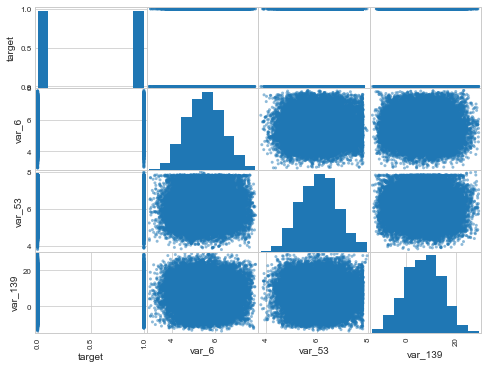

In [332]:
#Take the top most corr features(pos or neg) and plot
attributes = ["target","var_6","var_53","var_139"]
scatter_matrix(smote_train[attributes], figsize=(8,6))
plt.savefig('../data/processed/scatter_mat_after.png',bbox_inches='tight')

## The correlation of target increased to a max of 0.139 for this sub-sample, but overall again not much correlation
LogisticRegression depends on the how well we can draw a boundary between target class, so wont do any good here
Naive Bayes suits the cases where features are not dependent on each other
RandomForest has no assumptions of normalized data, or any other, so might be the best here

## Normalization

In [333]:
data.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,2.438924,-9.2834,5.1187,2.924591,-4.9200,...,4.4354,3.9642,3.1364,1.6910,2.918997,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,2.514643,7.0433,5.6208,2.805407,3.1468,...,7.6421,7.7214,2.5837,10.9516,2.736346,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,2.359202,-9.0837,6.9427,2.682083,-4.9193,...,2.9057,9.7905,1.6704,1.6858,3.072888,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,2.532474,-1.8361,5.8428,2.703038,-5.8609,...,4.4666,4.7433,0.7178,1.4214,3.137002,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,2.507744,2.4486,5.9405,2.957584,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,2.586831,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [334]:
#normalize except target in both train and test datasets
bk = smote_train
for i in smote_train.columns:
    if i == 'target':
        continue
    smote_train[i] = (smote_train[i] - smote_train[i].min())/(smote_train[i].max() - smote_train[i].min())
    test[i] = (test[i] - test[i].min())/(test[i].max() - test[i].min())
smote_train.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
0,0.327630,0.520703,0.662225,0.349199,0.392884,0.654166,0.407977,0.457003,0.360458,0.572116,...,0.367705,0.261284,0.625511,0.733036,0.594653,0.302335,0.564072,0.583536,0.690635,1
1,0.521901,0.337921,0.399937,0.324227,0.569738,0.545813,0.661675,0.674799,0.249456,0.514520,...,0.564724,0.530608,0.851441,0.202123,0.599898,0.389446,0.371923,0.338175,0.650476,0
2,0.422311,0.207322,0.211833,0.531513,0.582533,0.758045,0.683852,0.371775,0.349852,0.484102,...,0.316931,0.493659,0.772409,0.531396,0.351263,0.270074,0.655999,0.285247,0.577387,0
3,0.177806,0.574446,0.797972,0.234328,0.753063,0.461876,0.474447,0.111702,0.638002,0.786679,...,0.486162,0.335181,0.715359,0.632519,0.587912,0.307945,0.446031,0.760221,0.752827,0
4,0.355413,0.615485,0.464479,0.364234,0.465378,0.707957,0.577150,0.584098,0.742579,0.742210,...,0.655223,0.435124,0.632469,0.340014,0.327215,0.766460,0.429770,0.495438,0.690232,0


# Alternative approach(Approach 2)
Top 100 features

Let us try taking best 100 features(top 100 correlation values wrt target) into train_top100 dataframe and compare them train dataframe(all 201 features) and see if any significant difference exists

In [335]:
corr_tmp = corr #Automatically take top 100 IV with greater correlation 
new_corr = abs(corr_tmp['target']).nlargest(101).values
larg_100 = abs(corr_tmp['target']).nlargest(101)

#Uncomment and see what all it has 
#larg_10.index.values, larg_10.values,larg_10
train_top100 = smote_train[larg_100.index.values]
train_top100.head(2)

,target,var_6,var_53,var_139,var_81,var_76,var_174,var_99,var_146,var_165,...,var_35,var_48,var_24,var_28,var_180,var_70,var_168,var_102,var_15,var_66
0,1,0.407977,0.943439,0.454635,0.408809,0.602464,0.692953,0.727831,0.820938,0.368976,...,0.620760,0.784553,0.323922,0.498294,0.508842,0.501162,0.530145,0.598591,0.513304,0.410467
1,0,0.661675,0.742193,0.354956,0.732060,0.604175,0.307739,0.438461,0.580202,0.404897,...,0.200699,0.681062,0.574047,0.553786,0.602297,0.356036,0.485595,0.541317,0.376140,0.969743


In [336]:
#Saving for future purpose
#smote_train.to_csv(processed_data_path,index=False)
smote_train = pd.read_csv(processed_data_path)
#data.head(1),data.shape
 



# Model Training
We need to split our data for taining and testing

Way1 is using random sampling

Way2 is using Kfolds cross validation

# Measuring the accuracy of model
classification metrics is not a good indication for imbalanced datasets Rather we use ROC 

Recall is also called sensitivity(TP rate - actual positive classes which were correctly classified)

Specificity is also called TN rate(actual negative classes which were correctly classified)

F1 score = combination of recall and precision 

Depending on the kind of problem you want to solve you may want to maximize either sensitivity or specificity.

confusion matrix considers only a single threshold value to generate a curve vs all possibe classification thresholds are considered for ROC curve

ROC compares TPR(y-axis) vs FPR(x-axis) 
More the area under the curve, better the model 

E.g. Paper published in a Journal positives(admitted) = 250 negatives(not admitted) =250
Based on prob threshold(>0.6 generally) which we set, we classify into classes.

If your model did not do well, then distribution plot for both classes will be overalapping for a significant area and the roc curve will be a 45 degree line, telling that model just did random guessing
TPR = TP / all positives FPR = FP/ all negatives

Curve generation E.g. If threshold is say 0.8,then the area to the right of the curve is admitted and to the left is not admitted 

TPR = 50(red pixels to the right of threshold line)/250(total red(pos) pixels) 

FPR = 0(blue pixels to the right of threshold line)/250(total red(pos) pixels)

plot (FPR,TPR) --> (0,0.2) E.g. If threshold is say 0.5, then the area to the right of the curve is admitted and to the left is not admitted TPR = 230(red pixels to the right of threshold line)/250(total red(pos) pixels)=0.94 FPR = 125(blue pixels to the right of threshold line)/250(total red(pos) pixels)=0.5 plot (FPR,TPR) --> (0.5,0.94) All the possible classificaton thresholds are considered and points are plotted to fit a curve

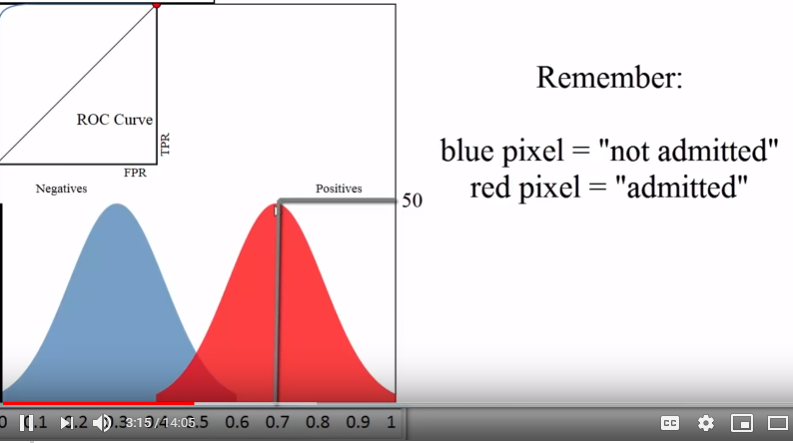
So for good model, curve will be hugging the topmost left corner, more area under the curve and auc should be relatively higher



In [375]:
#Function block
def plot_roc(iv_test,dv_test):
    dv_test_pred_proba = model.predict_proba(iv_test)[::,1]
    fpr, tpr, _ = roc_curve(dv_test,  dv_test_pred_proba)
    auc = roc_auc_score(dv_test,  dv_test_pred_proba)
    print(auc)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()


def cm_analysis(clf,iv_test, dv_test,dv_test_pred):
    #confusion matrix
    #here negative cases(one with malignant cancer) are imp to be diagonsed
    cm = pd.crosstab(dv_test,dv_test_pred)
    print(cm)
   
    acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])#the no of tp+tn/all
    specifity = (cm[1][1]/(cm[1][1]+cm[1][0]))*100#no of negatives correctly classified (Identification of NO cases)
    fnr  = (cm[0][1]/(cm[0][1]+cm[0][0]))*100#no of -ve wrongly classified, i.e. predicted as - but actually positive\
                                             #...wrong info saying he will not make a transaction *****

    recall = (cm[0][0]/(cm[0][1]+cm[0][0]))*100#no of actual +ve classes correctly classified(no of defaulters on loan)****************
    fpr = (cm[1][0]/ (cm[1][0]+cm[1][1]))*100#no of wrong positives , i.e predicted as + but actually negative...Wrongly telling that\
                                            #a customer will make a transaction
   
   
    print('************* Evaluation metrics************: ')
    print('(Specifity) Accuracy in Identifying customers not making a transaction :',specifity )
    print('(FPR) Wrongly telling a customer will make a transaction',fpr )
    print('**(RECALL) Accuracy in Identifying customers making a Transaction',recall )
    print('**(FNR) Wrongly telling a customer will not make a transaction',fnr )
    print(auc_util(clf,iv_test,dv_test))
    plot_roc(iv_test,dv_test)
    

def auc_util(clf,iv_test,dv_test):
    dv_test_proba = clf.predict_proba(iv_test)[::,1] 
        
    fpr,tpr,threshold = roc_curve(dv_test,dv_test_proba)
    #if np.isnan(fpr):
    #    print('YESSSSS')
    auc_ = auc(fpr,tpr)
        #if np.isnan(auc_):
        #    print(fpr,tpr)
    return auc_
    


## Way 1: Directly using train_test_split

accuracy  0.9027777777777778
col_0    0    1
row_0          
0      371    3
1       67  279
************* Evaluation metrics************: 
(Specifity) Accuracy in Identifying customers not making a transaction : 98.93617021276596
(FPR) Wrongly telling a customer will make a transaction 1.0638297872340425
**(RECALL) Accuracy in Identifying customers making a Transaction 84.70319634703196
**(FNR) Wrongly telling a customer will not make a transaction 15.296803652968036
0.9597694043460788
0.9597694043460788


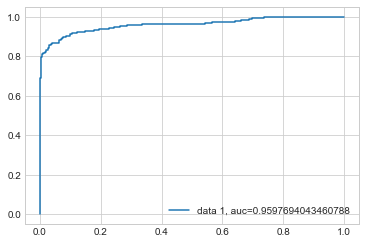

In [379]:
iv = smote_train.drop(['target'],axis=1)
dv= smote_train['target'].values
iv_train, iv_test, dv_train,dv_test = train_test_split(iv,dv, test_size = 0.2)#way 1

#model = LogisticRegression().fit(iv_train,dv_train)
dv_test_pred = model.predict(iv_test)
print('accuracy ' ,model.score(iv_test,dv_test))
cm_analysis(model,iv_test, dv_test,dv_test_pred)

accuracy  0.8930555555555556
col_0    0    1
row_0          
0      366    5
1       72  277
************* Evaluation metrics************: 
(Specifity) Accuracy in Identifying customers not making a transaction : 98.22695035460993
(FPR) Wrongly telling a customer will make a transaction 1.773049645390071
**(RECALL) Accuracy in Identifying customers making a Transaction 83.56164383561644
**(FNR) Wrongly telling a customer will not make a transaction 16.43835616438356
0.947690359054364
0.947690359054364


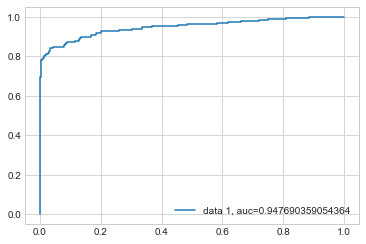

In [378]:
#Way 1: Directly using train_test_split

iv = smote_train.drop(['target'],axis=1)
dv= smote_train['target'].values
iv_train, iv_test, dv_train,dv_test = train_test_split(iv,dv, test_size = 0.2)#way 1

model = GaussianNB().fit(iv_train,dv_train)
dv_test_pred = model.predict(iv_test)
print('accuracy ' ,model.score(iv_test,dv_test))
cm_analysis(model,iv_test, dv_test,dv_test_pred)

accuracy  0.924958310172318
col_0     0     1
row_0            
0      3383   180
1       360  3273
************* Evaluation metrics************: 
(Specifity) Accuracy in Identifying customers not making a transaction : 94.7871416159861
(FPR) Wrongly telling a customer will make a transaction 5.2128583840139004
**(RECALL) Accuracy in Identifying customers making a Transaction 90.38204648677531
**(FNR) Wrongly telling a customer will not make a transaction 9.617953513224686
0.9752052995358061


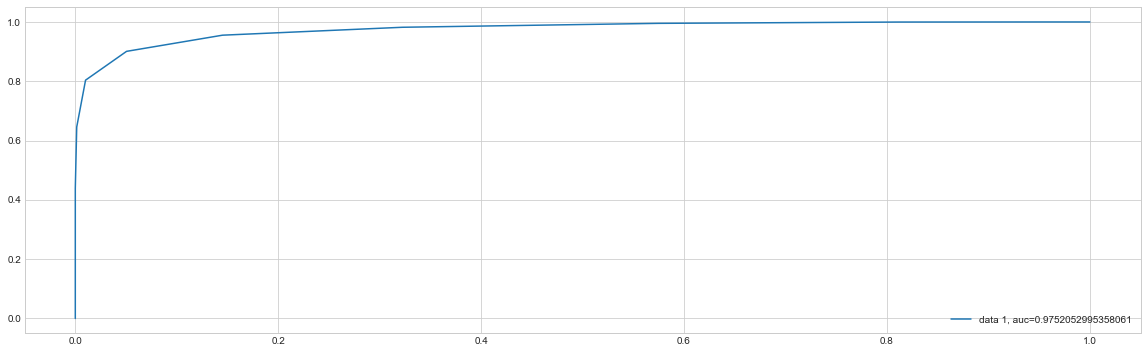

In [340]:
#Way 1: Directly using train_test_split

iv = smote_train.drop(['target'],axis=1)
dv= smote_train['target'].values
iv_train, iv_test, dv_train,dv_test = train_test_split(iv,dv, test_size = 0.2)#way 1

model = RandomForestClassifier().fit(iv_train,dv_train)
dv_test_pred = model.predict(iv_test)
print('accuracy ' ,model.score(iv_test,dv_test))
cm_analysis(iv_test, dv_test,dv_test_pred)

## Random forest hyper parameter tuning


accuracy  0.9958333333333333
col_0    0    1
row_0          
0      369    0
1        3  348
************* Evaluation metrics************: 
(Specifity) Accuracy in Identifying customers not making a transaction : 100.0
(FPR) Wrongly telling a customer will make a transaction 0.0
**(RECALL) Accuracy in Identifying customers making a Transaction 99.19354838709677
**(FNR) Wrongly telling a customer will not make a transaction 0.8064516129032258
0.9996139562535228
0.9996139562535228


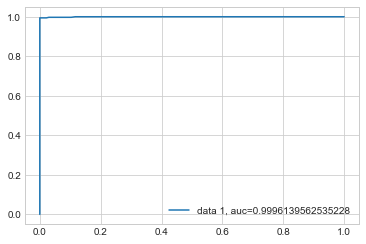

In [376]:
#Way 1: Directly using train_test_split
from sklearn.metrics import auc
iv = smote_train.drop(['target'],axis=1)
dv= smote_train['target'].values
iv_train, iv_test, dv_train,dv_test = train_test_split(iv,dv, test_size = 0.2)#way 1

model = RandomForestClassifier(n_estimators =100, max_features=150).fit(iv_train,dv_train)
dv_test_pred = model.predict(iv_test)
print('accuracy ' ,model.score(iv_test,dv_test))
cm_analysis(model,iv_test, dv_test,dv_test_pred)

# RESULT
-- RandomForest gives the best results( Recall is highest and fnr is the lowest among all) with auc = 0.98

SVC is the slowest since it becomes O(n^2 * k features), complexity is more and not included here as well

##  Way 2  Using Kfolds
Instead of using random sampling for splitting our data, we can use KFold method with certain no of fold(iterations) and took the average of those for comparisions.

I declared a helper class to test my model with KFolds = 5

In [380]:
from sklearn.metrics import auc
#class to extend sklearn classifier
class sklearnHelper(object):
    def __init__(self, clf, seed = 0, params = None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()
    def train(self, train_iv, train_dv):
        self.clf.fit(train_iv, train_dv)#train on training data
    def predict(self, test_iv):
        return self.clf.predict(test_iv)
    def score(self, iv_test, dv_test):
        return self.clf.score(iv_test, dv_test)
    def feature_importances(self,x, y):
        print(self.clf.fit(x,y).feature_importances_)
    def auc_model(self,iv_test,dv_test):
        dv_test_proba = self.clf.predict_proba(iv_test)[::,1] 
        
        fpr,tpr,threshold = roc_curve(dv_test,dv_test_proba)
        
        auc_ = auc(fpr,tpr)
        #if np.isnan(auc_):
        #    print(fpr,tpr)
        return auc_
    

In [381]:
SEED=0
NFOLDS =5
kf = KFold(n_splits = 5)
rf_params = {
    'n_estimators': 50
    
}
# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'rbf',
    'C' : 0.25,
    'gamma':0.01
    }

lr_params ={
    'C' :0.1
}


In [382]:
#Since we have the helper class declared, we can call same class with object of respective class, initialize the parameters
#and get the object indentifier for each classifier being passed
#call with object of respective class and initialize the parameters

rf = sklearnHelper(clf = RandomForestClassifier, seed = SEED,params = None)
svm = sklearnHelper(clf=SVC, seed=SEED, params = svc_params)
nb = sklearnHelper(clf=GaussianNB, seed=SEED, params=None)
lr = sklearnHelper(clf = LogisticRegression, seed = SEED,params = lr_params)


In [383]:
def get_oof(data,clf, iv, dv):
    i = 0
    sum_score = 0
    it_score = 0
    sum_auc = 0
    count_auc = 0
    for train_index,test_index in kf.split(range(data.shape[0])):
        iv_train, iv_test, dv_train,dv_test = iv[train_index], iv[test_index]\
                                ,dv[train_index], dv[test_index]
        #print('len ',len(iv_train),len(iv_test),len(dv_train),len(dv_test))   
        clf.train(iv_train, dv_train)
        dv_test_pred = clf.predict(iv_test)
        it_score = clf.score(iv_test, dv_test)
        sum_score += it_score
        print('model score :',it_score)
        
        #To be updated later
        
        auc_ = clf.auc_model(iv_test,dv_test)
        if np.isnan(auc_) != True:
            sum_auc += auc_
            print('auc :',auc_)
            count_auc += 1
        else:
            print('fpr is nan')
        #auc_for_model.append([auc])
    
        

    return (sum_score/NFOLDS, sum_auc/count_auc,[],[])

def get_max(result):
    #print(result)
    max = 0
    for item in result.values():
        item_ = item[0]
        if max < item_:
            max = item_
    return max

   


## Model performance with all columns passed

In [385]:
iv = smote_train.drop(['target'], axis =1).values
dv = smote_train['target'].values



print('RandomForestClasssifier-------')
rf_avg_score,rf_auc_score,fpr,tpr = get_oof(smote_train, rf, iv, dv)
print('Average RandomForestClasssifier score', rf_avg_score)
print('Average RandomForestClasssifier auc score', rf_auc_score)

print('SVM-----------------')
svm_avg_score , svm_auc,fpr,tpr = -1,[],0,0#get_oof(smote_train, svm, iv, dv)
#SVM almost does while calculating the distances.
#Time comlexity becomes no_samples^2 * no_features for eac feature it needs to calculates svm,so skipping SVm
print('Average SVM score', svm_avg_score)

print('NAIVE BAYES-----------------')
nb_avg_score,nb_auc_score,fpr,tpr = get_oof(smote_train, nb, iv, dv)
print('Average nb score', nb_avg_score)
print('Average nb auc score', nb_auc_score)

print('logisticRegression--------')
lr_avg_score, lr_auc_score,fpr,tpr= get_oof(smote_train, lr, iv, dv)
print('Average lr score', lr_avg_score)
print('Average lr auc score', lr_auc_score)

print("Training complete")
result = {'RandomForestClasssifier':(rf_avg_score,rf_auc,fpr,tpr),
         'svm':(svm_avg_score,svm_auc,fpr,tpr),
         'naive bayes': (nb_avg_score,nb_auc,fpr,tpr),
         'LogisticRegression':(lr_avg_score,lr_auc,fpr,tpr)}
upd_result = dict((val[0],key) for key,val in result.items())#create a dic by rev 'result' pairs and extracting key with max value
print('%%%%%%%%%% BEST model :',upd_result[get_max(result)] ,'-----score',get_max(result))
      


RandomForestClasssifier-------
model score : 0.9416666666666667
auc : 0.949893991338867
model score : 0.9319444444444445
auc : 0.9313603301732593
model score : 0.9388888888888889
auc : 0.9740176452803914
model score : 0.8428372739916551
fpr is nan
model score : 0.8497913769123783
fpr is nan
Average RandomForestClasssifier score 0.9010257301808066
Average RandomForestClasssifier auc score 0.9517573222641725
SVM-----------------
Average SVM score -1
NAIVE BAYES-----------------
model score : 0.9097222222222222
auc : 0.6914922410682064
model score : 0.9125
auc : 0.6920766590389017
model score : 0.8986111111111111
auc : 0.9104176782622239
model score : 0.8915159944367177
fpr is nan
model score : 0.8762169680111266
fpr is nan
Average nb score 0.8977132591562356
Average nb auc score 0.7646621927897773
logisticRegression--------
model score : 0.7583333333333333
auc : 0.9059680620714544
model score : 0.7583333333333333
auc : 0.9134929715593331
model score : 0.8166666666666667
auc : 0.927403322

## RESULT : undersample vs oversample
undersampled data naive bayes performs the best

randomforest and naice bayes perform almost equal in oversampled

randomforest doesnot perform well with lesser no of observations

## Model performance with top 100 feature

In [346]:
iv = train_top100.drop(['target'], axis =1).values
dv = train_top100['target'].values



print('RandomForestClasssifier-------')
rf_avg_score,rf_auc,fpr,tpr = get_oof(train_top100, rf, iv, dv)
print('Average RandomForestClasssifier score', rf_avg_score)

print('SVM-----------------')
svm_avg_score , svm_auc,fpr,tpr = -1,[],0,0#get_oof(train_top100, svm, iv, dv)
#SVM almost does while calculating the distances.
#Time comlexity becomes no_samples^2 * no_features for eac feature it needs to calculates svm,so skipping SVm
print('Average SVM score', svm_avg_score)

print('NAIVE BAYES-----------------')
nb_avg_score,nb_auc,fpr,tpr = get_oof(train_top100, nb, iv, dv)
print('Average nb score', nb_avg_score)

print('logisticRegression--------')
lr_avg_score, lr_auc,fpr,tpr= get_oof(train_top100, lr, iv, dv)
print('Average lr score', lr_avg_score)

print("Training complete")
result = {'RandomForestClasssifier':(rf_avg_score,rf_auc,fpr,tpr),
         'svm':(svm_avg_score,svm_auc,fpr,tpr),
         'naive bayes': (nb_avg_score,nb_auc,fpr,tpr),
         'LogisticRegression':(lr_avg_score,lr_auc,fpr,tpr)}
upd_result = dict((val[0],key) for key,val in result.items())#create a dic by rev 'result' pairs and extracting key with max value
print('%%%%%%%%%% BEST model :',upd_result[get_max(result)] ,'-----score',get_max(result))
      


RandomForestClasssifier-------
0.8910505836575876
0.8929961089494164
0.9181489716509171
0.7996108949416343
0.7880767092829349
Average RandomForestClasssifier score 0.857976653696498
SVM-----------------
Average SVM score -1
NAIVE BAYES-----------------
0.8132295719844358
0.8130906058921623
0.8282379099499723
0.8382434685936632
0.8451917732073374
Average nb score 0.8275986659255142
logisticRegression--------
0.7240133407448582
0.7091439688715954
0.7695942190105615
0.6839911061700945
0.6910783768760422
Average lr score 0.7155642023346305
Training complete
%%%%%%%%%% BEST model : RandomForestClasssifier -----score 0.857976653696498


# train beats train_top100
Model gives best performance when all features are passed, rather than top 100 correlated one, since the corr itself is very low

## Plot feature importances in randomforest
We selected randomforest, but just for info sake lets plot this also

In [347]:
iv = data.drop(['target'],axis=1)
dv=data['target'].values
iv_train, iv_test, dv_train,dv_test = train_test_split(iv,dv, test_size = 0.2)#way 1
model = RandomForestClassifier().fit(iv_train, dv_train)
#f = pd.DataFrame(model.feature_importances_.reshape(1,-1),columns=data.drop(['Survived'],axis=1).columns.values)
cols = data.drop(['target'],axis=1).columns
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': model.feature_importances_})
feature_dataframe.head(1)



,features,Random Forest feature importances
0,var_0,0.006263


In [348]:
model.score(iv_test,dv_test)

0.900525

In [355]:
feature_dataframe['Random Forest feature importances'].nlargest(10)

81     0.012496
12     0.009757
139    0.009081
80     0.008234
174    0.008188
109    0.007931
99     0.007902
166    0.007853
148    0.007828
53     0.007757
Name: Random Forest feature importances, dtype: float64

In [352]:
#model.feature_importances_

trace = go.Scatter(y = feature_dataframe['Random Forest feature importances'].values,
                  x = feature_dataframe['features'].values,
                  mode = 'markers',
                  marker = dict(sizemode = 'diameter', sizeref = 1,size = 25,
                                color = feature_dataframe['Random Forest feature importances'].values,
                                colorscale='Portland',showscale=True),
                  text = feature_dataframe['features'].values)
layout = go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)
plt.savefig('../data/processed/rf_feature_imp.png',bbox_inches='tight')


## It's time to predict the result for test data
Now that we know RandomForest fits better, we can use all of the train data to feed the model
 

In [64]:

iv = data.drop(['target'],axis=1)
dv=data['target'].values
iv_test = test#.drop(['target'],axis=1)
model = RandomForestClassifier().fit(iv,dv)#Train the model using full training excel
#Let's predict for actual test data
dv_test_pred = model.predict(iv_test)
iv_test['target'] = dv_test_pred

#write back the results
iv_test.to_csv(submitted_data_path,index=False)



## FUN ACTIVITY : Just to compare
Without any pre-processing on data, naive bayes is performing the best and randomforest score goes down. One possible reason could be the corelation being very low, relative to the processed data

In [67]:
#take a stratified sample
dv= data['target']
rest,sample = train_test_split(data, test_size = 0.1,stratify=dv)
smote_train = sample.drop(['ID_code'], axis =1)#smote_train points to sample created above from whole training set

iv = smote_train.drop(['target'], axis =1).values#Get the independent and dependent variables
dv = smote_train['target'].values


#Start fitting the models
print('RandomForestClasssifier-------')
rf_avg_score,rf_auc,fpr,tpr = get_oof(smote_train, rf, iv, dv)
print('Average RandomForestClasssifier score', rf_avg_score)

print('SVM-----------------')
svm_avg_score , svm_auc,fpr,tpr = -1,[],0,0#get_oof(smote_train, svm, iv, dv)
#SVM almost does while calculating the distances.
#Time comlexity becomes no_samples^2 * no_features for eac feature it needs to calculates svm,so skipping SVm
print('Average SVM score', svm_avg_score)

print('NAIVE BAYES-----------------')
nb_avg_score,nb_auc,fpr,tpr = get_oof(smote_train, nb, iv, dv)
print('Average nb score', nb_avg_score)

print('logisticRegression--------')
lr_avg_score, lr_auc,fpr,tpr= get_oof(smote_train, lr, iv, dv)
print('Average lr score', lr_avg_score)

print("Training complete")
result = {'RandomForestClasssifier':(rf_avg_score,rf_auc,fpr,tpr),
         'svm':(svm_avg_score,svm_auc,fpr,tpr),
         'naive bayes': (nb_avg_score,nb_auc,fpr,tpr),
         'LogisticRegression':(lr_avg_score,lr_auc,fpr,tpr)}
upd_result = dict((val[0],key) for key,val in result.items())#create a dic by rev 'result' pairs and extracting key with max value
print('%%%%%%%%%% BEST model :',upd_result[get_max(result)] ,'-----score',get_max(result))
      


RandomForestClasssifier-------
0.9015
0.89975
0.891
0.898
0.9055
Average RandomForestClasssifier score 0.89915
SVM-----------------
Average SVM score -1
NAIVE BAYES-----------------
0.91975
0.925
0.91225
0.91775
0.92625
Average nb score 0.9201999999999998
logisticRegression--------
0.91125
0.91375
0.905
0.9095
0.918
Average lr score 0.9115
Training complete
%%%%%%%%%% BEST model : naive bayes -----score 0.9201999999999998


In [88]:
iv = smote_train.drop(['target'], axis =1).values
dv = smote_train['target'].values



print('RandomForestClasssifier-------')
rf_avg_score,rf_auc,fpr,tpr = get_oof(smote_train, rf, iv, dv)
print('Average RandomForestClasssifier score', rf_avg_score)

print('SVM-----------------')
svm_avg_score , svm_auc,fpr,tpr = -1,[],0,0#get_oof(smote_train, svm, iv, dv)
#SVM almost does while calculating the distances.
#Time comlexity becomes no_samples^2 * no_features for eac feature it needs to calculates svm,so skipping SVm
print('Average SVM score', svm_avg_score)

print('NAIVE BAYES-----------------')
nb_avg_score,nb_auc,fpr,tpr = get_oof(smote_train, nb, iv, dv)
print('Average nb score', nb_avg_score)

print('logisticRegression--------')
lr_avg_score, lr_auc,fpr,tpr= get_oof(smote_train, lr, iv, dv)
print('Average lr score', lr_avg_score)

print("Training complete")
result = {'RandomForestClasssifier':(rf_avg_score,rf_auc,fpr,tpr),
         'svm':(svm_avg_score,svm_auc,fpr,tpr),
         'naive bayes': (nb_avg_score,nb_auc,fpr,tpr),
         'LogisticRegression':(lr_avg_score,lr_auc,fpr,tpr)}
upd_result = dict((val[0],key) for key,val in result.items())#create a dic by rev 'result' pairs and extracting key with max value
print('%%%%%%%%%% BEST model :',upd_result[get_max(result)] ,'-----score',get_max(result))
      


RandomForestClasssifier-------
0.90275
0.89775
0.8925
0.898
0.90625
Average RandomForestClasssifier score 0.8994500000000001
SVM-----------------
Average SVM score -1
NAIVE BAYES-----------------
0.91975
0.925
0.91225
0.91775
0.92625
Average nb score 0.9201999999999998
logisticRegression--------
0.91025
0.91325
0.9035
0.907
0.91675
Average lr score 0.9101500000000001
Training complete
%%%%%%%%%% BEST model : naive bayes -----score 0.9201999999999998


## Precision- Recall curve

In [13]:
data.target.value_counts()
# since our data is largely imbalanced, we shall see precision-recall curve

0    17990
1     2010
Name: target, dtype: int64

In [14]:
iv = data.drop(['target'],axis=1)
dv = data['target']
iv_train, iv_test, dv_train, dv_test = train_test_split(iv,dv,test_size=0.2)
model = GaussianNB().fit(iv_train,dv_train)

In [22]:
from sklearn.metrics import precision_recall_curve,auc, average_precision_score

In [25]:
dv_test_pred_proba = model.predict_proba(iv_test)[::,1]
prec, recall,thresh = precision_recall_curve(dv_test,dv_test_pred_proba )
average_precision_score(dv_test,dv_test_pred_proba )

0.6112979450806849

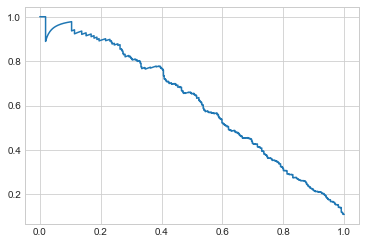

In [27]:
plt.plot(recall,prec)

In [28]:
auc(recall,prec)

0.6107881725561826

# Now let us clean our data and see the same

In [60]:
iv = data.drop(['target'],axis=1)
dv = data['target']
iv_train, iv_test, dv_train, dv_test = train_test_split(iv,dv,test_size=0.2)
model = GaussianNB().fit(iv_train,dv_train)
dv_test_pred_proba = model.predict_proba(iv_test)[::,1]
prec, recall,thresh = precision_recall_curve(dv_test,dv_test_pred_proba )
#Precision-recall score
average_precision_score(dv_test,dv_test_pred_proba )

0.5866495636703433

In [61]:
#auc score
roc_auc_score(dv_test,dv_test_pred_proba)

0.8892256113774737

# hyper-parameter tuning
TBD